In [1]:
import numpy as np
import h5py
import os
import configparser
from distutils import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

import torch
from The_Payne.utils import read_in_neural_network

import sys
sys.path.append('../')
from analysis_fns import apstarwavegrid
from network import CycleSN
from training_fns import PayneObservedDataset, batch_to_cuda, create_synth_batch
from analysis_fns import plot_progress, apstarwavegrid, tsne_domain_analysis

model_name = 'paynetopayne_nozsplit_1'

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [2]:
# Directories
cur_dir = '..'
config_dir = os.path.join(cur_dir, 'configs/')
model_dir = os.path.join(cur_dir, 'models/')
progress_dir = os.path.join(cur_dir, 'progress/')
data_dir = os.path.join(cur_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']
print('\nCreating model: %s'%model_name)
print('\nConfiguration:')
for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])


Creating model: paynetopayne_nozsplit_1

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_obs: PAYNE_NL.h5
  TRAINING
    batchsize: 8
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    learning_rate_discriminator: 0.0001
    loss_weight_rec: 5e3
    loss_weight_cc: 5e3
    loss_weight_gen: 1
    loss_weight_dis: 1
    lr_decay_batch_iters: 5e4
    lr_decay: 0.7
    total_batch_iters: 3e5
    use_real_as_true: False
    mask_synth_lines: True
  ARCHITECTURE
    num_pixels: 7167
    activation: LeakyReLU
    conv_filts_ae_dom: [32, 64, 128]
    conv_filt_lens_ae_dom: [7, 7, 7]
    conv_strides_ae_dom: [4, 4, 4]
    conv_filts_ae_sh: [256, 512]
    conv_filt_lens_ae_sh: [7, 7]
    conv_strides_ae_sh: [4, 4]
    conv_filts_ae_sp: [32, 64]
    conv_filt_lens_ae_sp: [7, 7]
    conv_strides_ae_sp: [4, 4]
    enc_out_norm: True
    shared_z_filters: 25
    split_z_filters: 0
    conv_filts_dis_x: [16, 32, 64, 128, 256]
    conv_stri

In [3]:
# BUILD THE NETWORKS

# Load the Payne pre-trained weights
emulator_coeffs = read_in_neural_network()

print('\nBuilding networks...')
model = CycleSN(architecture_config, emulator_coeffs, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(model.emulator)
print('\n\nENCODER_synth and ENCODER_obs ARCHITECTURE:\n')
print(model.encoder_synth)
print('\n\nENCODER_sh ARCHITECTURE:\n')
print(model.encoder_sh)
if model.use_split:
    print('\n\nENCODER_sp ARCHITECTURE:\n')
    print(model.encoder_sp)
    print('\n\nDECODER_sp ARCHITECTURE:\n')
    print(model.decoder_sp)
print('\n\nDECODER_sh ARCHITECTURE:\n')
print(model.decoder_sh)
print('\n\nDECODER_synth and DECODER_obs ARCHITECTURE:\n')
print(model.decoder_synth)
print('\n\nDISCRIM_synth and DISCRIM_obs ARCHITECTURE:\n')
print(model.discriminator_synth)


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER_synth and ENCODER_obs ARCHITECTURE:

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
  (5): LeakyReLU(negative_slope=0.1)
)


ENCODER_sh ARCHITECTURE:

Sequential(
  (0): Conv1d(128, 256, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(256, 512, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(512, 25, kernel_size=(1,), stride=(1,))
  (5): InstanceNorm1d(25, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)


DECODER_s

In [4]:
# Load pre-trained weights
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')

print('\nLoading saved model...')
# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
cur_iter = checkpoint['batch_iters']+1
losses = dict(checkpoint['losses'])

# Load model weights
model.load_state_dict(checkpoint['cycle_model'])


Loading saved model...


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

0.04798153042793274 0.004621683154255152 0.007426015567034483 0.0127626433968544 0.02068626880645752 

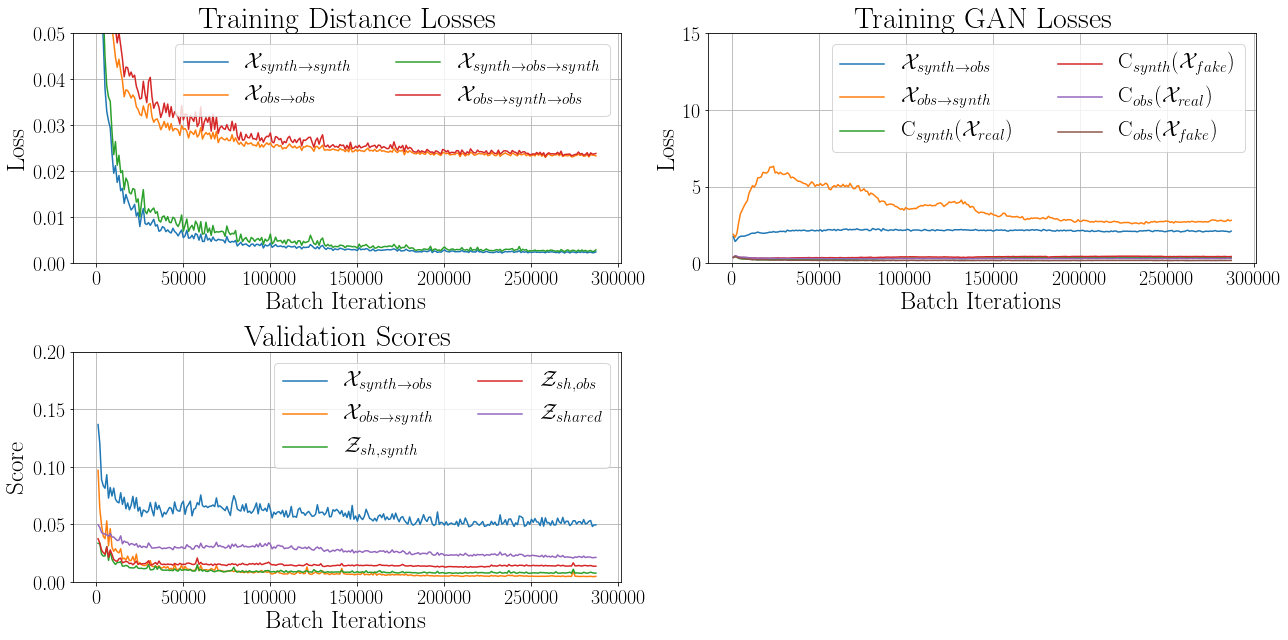

In [5]:
%matplotlib inline
plot_progress(losses, y_lims=[(0,0.05),(0,15),(0,0.2)], use_split=model.use_split)#, 
              #savename='../figures/'+model_name+'_training_progress.png')

In [6]:
# DATA

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load line mask
line_mask = np.load(data_dir+'mock_missing_lines.npz')['total_mask']
line_mask = torch.from_numpy(np.array(line_mask, dtype=np.uint8))

# Dataset
obs_dataset = PayneObservedDataset(data_file_obs, obs_domain='PAYNE', dataset='val', 
                                   x_mean=x_mean, x_std=x_std, collect_x_mask=False)

# Validation set that consists of matching pairs in the synthetic and observed domains
obs_val_set = obs_dataset.__getitem__(1000, dataset='val', return_labels=True, collect_preceeding=True) 
synth_val_set = create_synth_batch(model, x_mean, x_std, y=obs_val_set['y'], line_mask=line_mask,
                                  use_cuda=use_cuda)
# Switch to GPU
if use_cuda:
    obs_val_set = batch_to_cuda(obs_val_set)
    synth_val_set = batch_to_cuda(synth_val_set)

In [7]:
# Evaluate validation set
model.eval_mode()

# Encoding
zsh_synth = model.synth_to_z(synth_val_set['x'].detach())
if model.use_split:
    zsh_obs, zsp_obs = model.obs_to_z(obs_val_set['x'].detach())
else:
    zsh_obs = model.obs_to_z(obs_val_set['x'].detach())

# Reconstruction
x_synthsynth = model.z_to_synth(zsh_synth)
if model.use_split:
    x_obsobs = model.z_to_obs(zsh_obs, zsp_obs)
else:
    x_obsobs = model.z_to_obs(zsh_obs)

# Cross-domain mapping
if model.use_split:
    # Here we use the z_split from x_obs to generate x_synthobs
    x_synthobs = model.z_to_obs(zsh_synth, zsp_obs)
else:
    x_synthobs = model.z_to_obs(zsh_synth)
x_obssynth = model.z_to_synth(zsh_obs)

# Cycle-Reconstruction
zsh_obssynth = model.synth_to_z(x_obssynth)
if model.use_split:
    zsh_synthobs, zsp_synthobs = model.obs_to_z(x_synthobs)
    # Here we again use the original z_split from x_obs to cycle-reconstuct x_obssynthobs
    x_obssynthobs = model.z_to_obs(zsh_obssynth, zsp_obs)
else:
    zsh_synthobs = model.obs_to_z(x_synthobs)
    x_obssynthobs = model.z_to_obs(zsh_obssynth)
x_synthobssynth = model.z_to_synth(zsh_synthobs)

In [8]:
# Return to numpy
x_synth_val = synth_val_set['x'].data.cpu().numpy()
x_obs_val = obs_val_set['x'].data.cpu().numpy()
zsh_synth = zsh_synth.data.cpu().numpy()
zsh_obs = zsh_obs.data.cpu().numpy()
x_synthsynth = x_synthsynth.data.cpu().numpy()
x_obsobs = x_obsobs.data.cpu().numpy()
x_synthobs = x_synthobs.data.cpu().numpy()
x_obssynth = x_obssynth.data.cpu().numpy()
x_synthobssynth = x_synthobssynth.data.cpu().numpy()
x_obssynthobs = x_obssynthobs.data.cpu().numpy()

# Denormalize
x_synth_val = x_synth_val*x_std + x_mean
x_obs_val = x_obs_val*x_std + x_mean
x_synthsynth = x_synthsynth*x_std + x_mean
x_obsobs = x_obsobs*x_std + x_mean
x_synthobs = x_synthobs*x_std + x_mean
x_obssynth = x_obssynth*x_std + x_mean
x_synthobssynth = x_synthobssynth*x_std + x_mean
x_obssynthobs = x_obssynthobs*x_std + x_mean

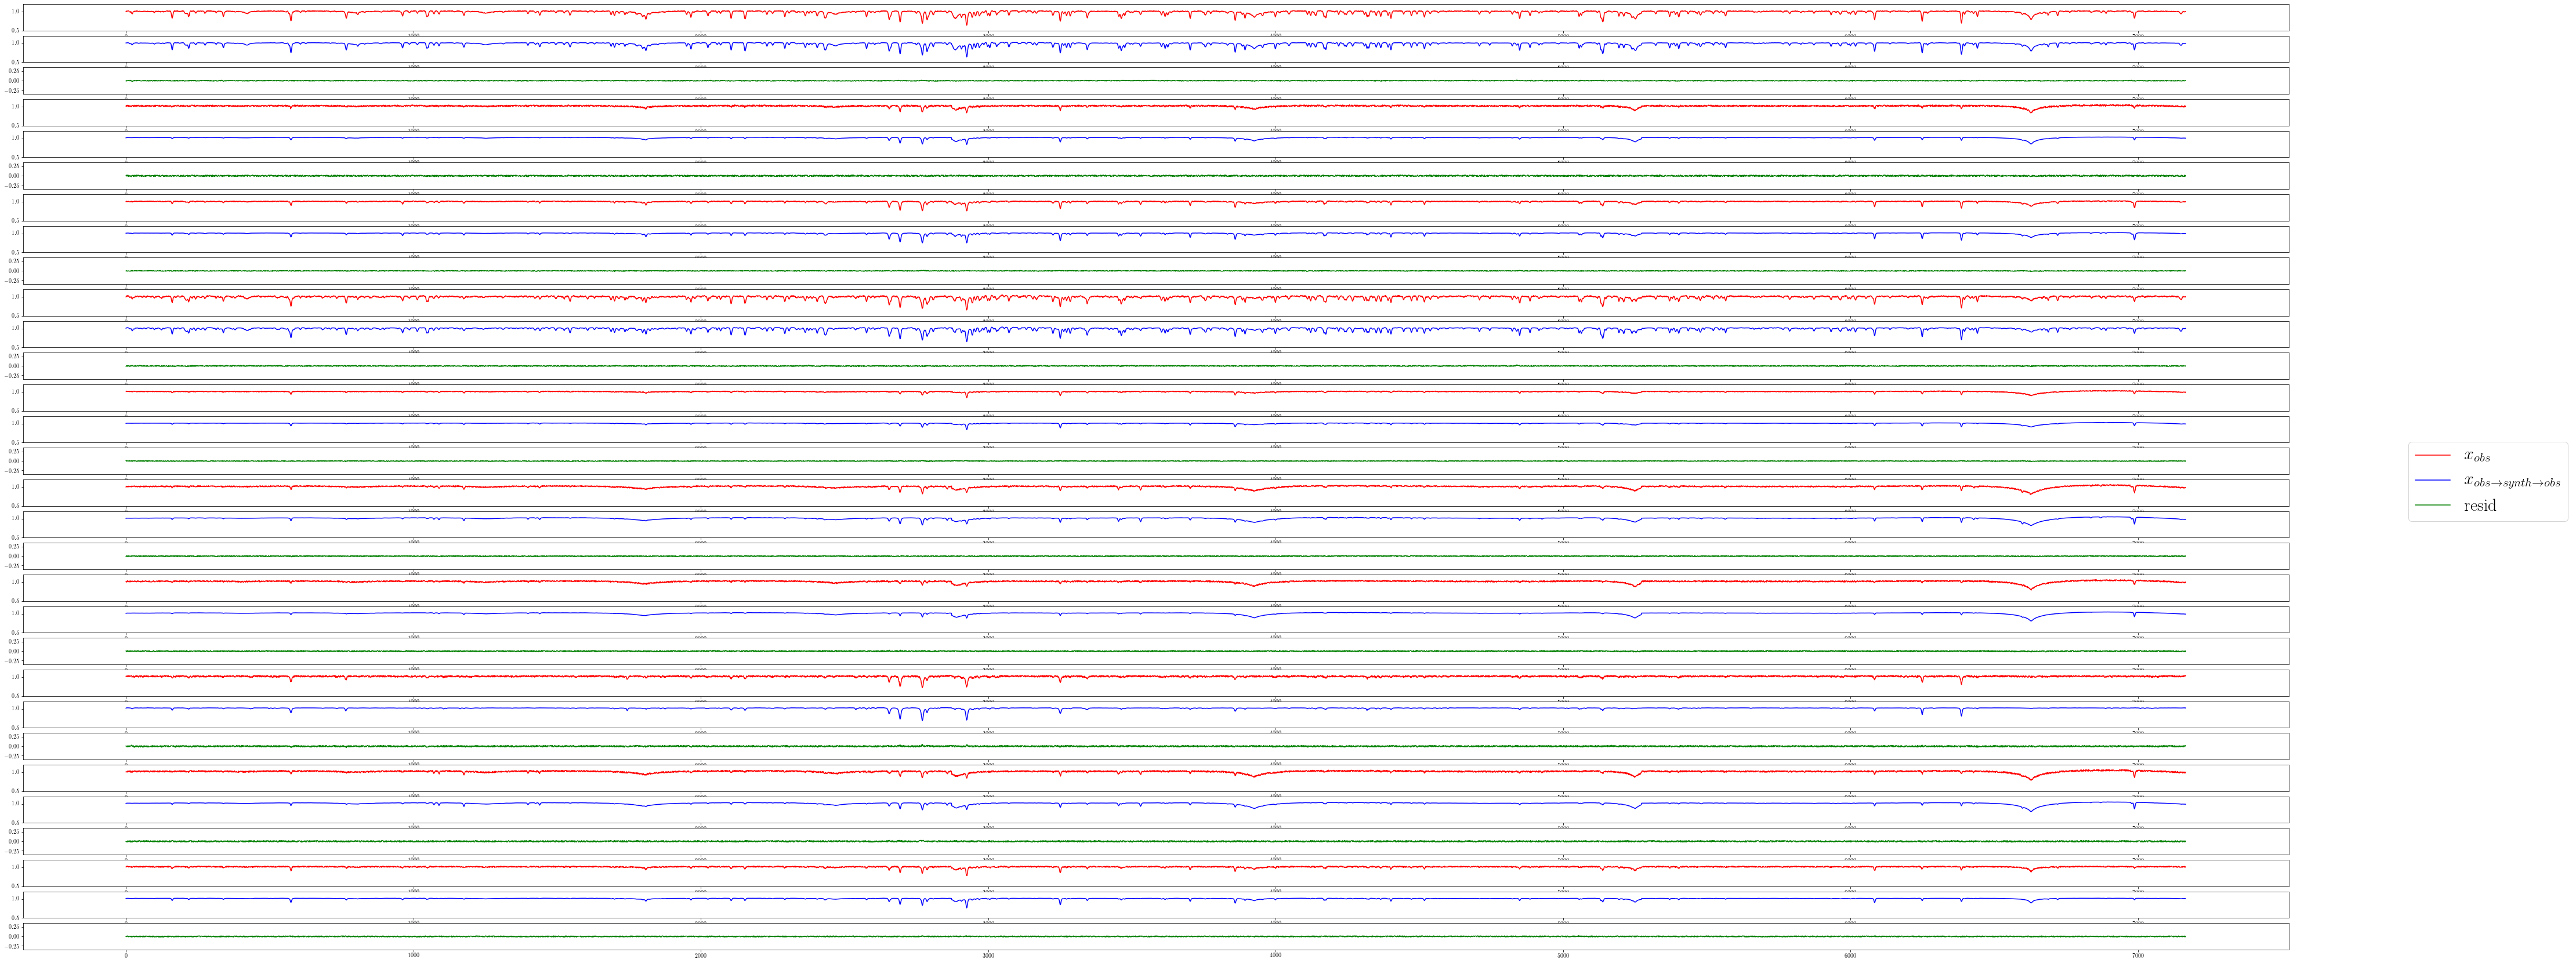

In [9]:
# Randomly select 10 indices
test_indices = np.random.choice(np.arange(0,len(x_obs_val)), size=10,
                                replace=False)

# Calculate residulal
x_obs_resid = (x_obs_val-x_obssynthobs)

plt.close('all')
# Plot test results
fig, axes = plt.subplots(30,1,figsize=(70, 30))
for i, indx in enumerate(test_indices):
    orig, = axes[i*3].plot(x_obs_val[indx],c='r')
    axes[i*3].set_ylim((0.5,1.2))
    pred, = axes[1+3*i].plot(x_obssynthobs[indx],c='b')
    axes[1+3*i].set_ylim((0.5,1.2))
    resid, = axes[2+3*i].plot(x_obs_resid[indx],c='g')
    axes[2+3*i].set_ylim((-0.35,0.35))
fig.legend([orig, pred, resid],[r'$x_{obs}$', r'$x_{obs\rightarrow synth \rightarrow obs}$', r'resid'],
          loc='center right', fontsize=30)  
plt.show()

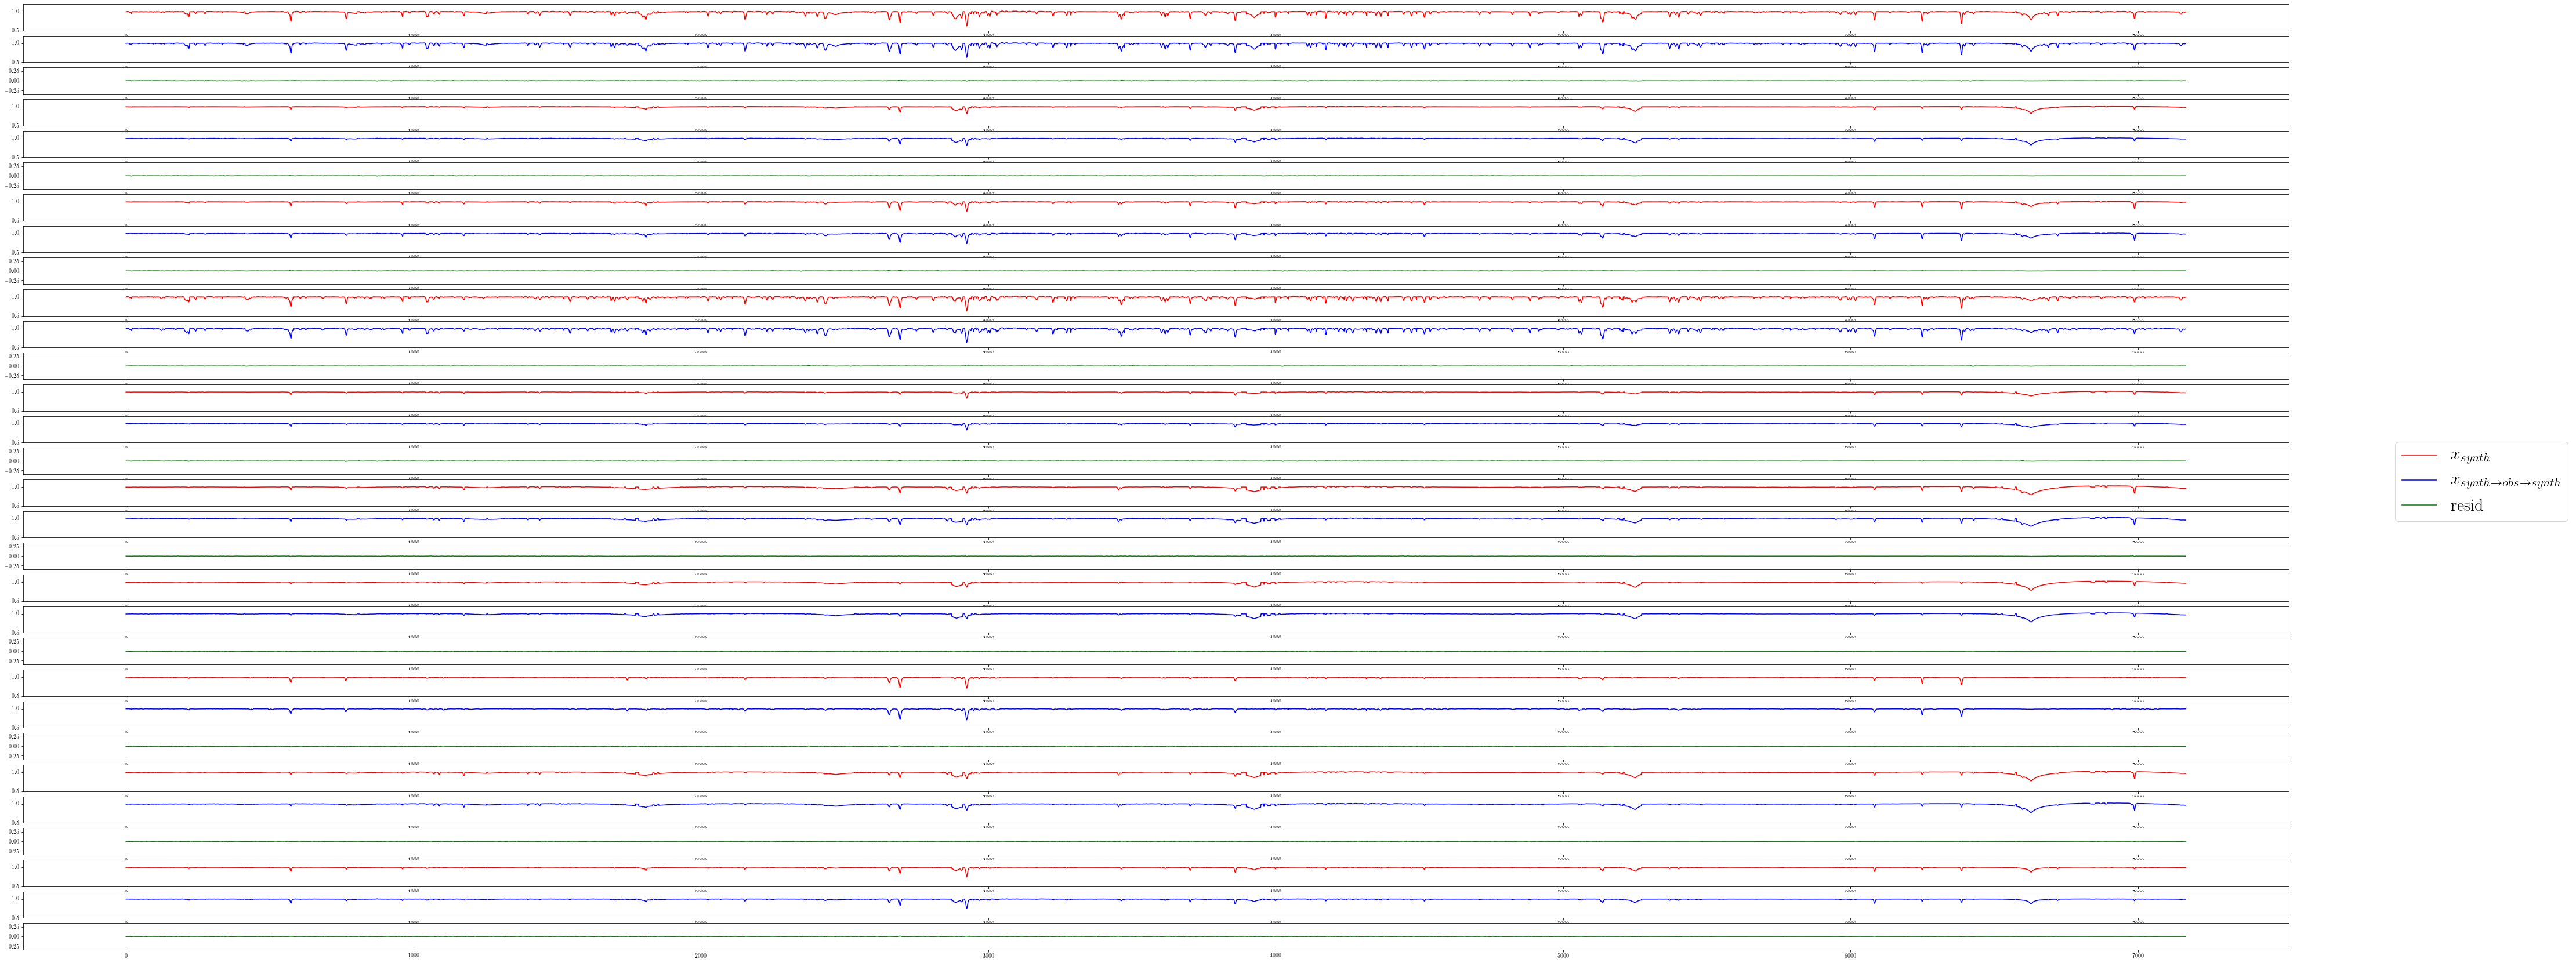

In [10]:
# Calculate residulal
x_synth_resid = (x_synth_val-x_synthobssynth)

plt.close('all')
# Plot test results
fig, axes = plt.subplots(30,1,figsize=(70, 30))
for i, indx in enumerate(test_indices):
    orig, = axes[i*3].plot(x_synth_val[indx],c='r')
    axes[i*3].set_ylim((0.5,1.2))
    pred, = axes[1+3*i].plot(x_synthobssynth[indx],c='b')
    axes[1+3*i].set_ylim((0.5,1.2))
    resid, = axes[2+3*i].plot(x_synth_resid[indx],c='g')
    axes[2+3*i].set_ylim((-0.35,0.35))
fig.legend([orig, pred, resid],[r'$x_{synth}$', r'$x_{synth\rightarrow obs\rightarrow synth}$', r'resid'],
          loc='center right', fontsize=30)  
plt.show()

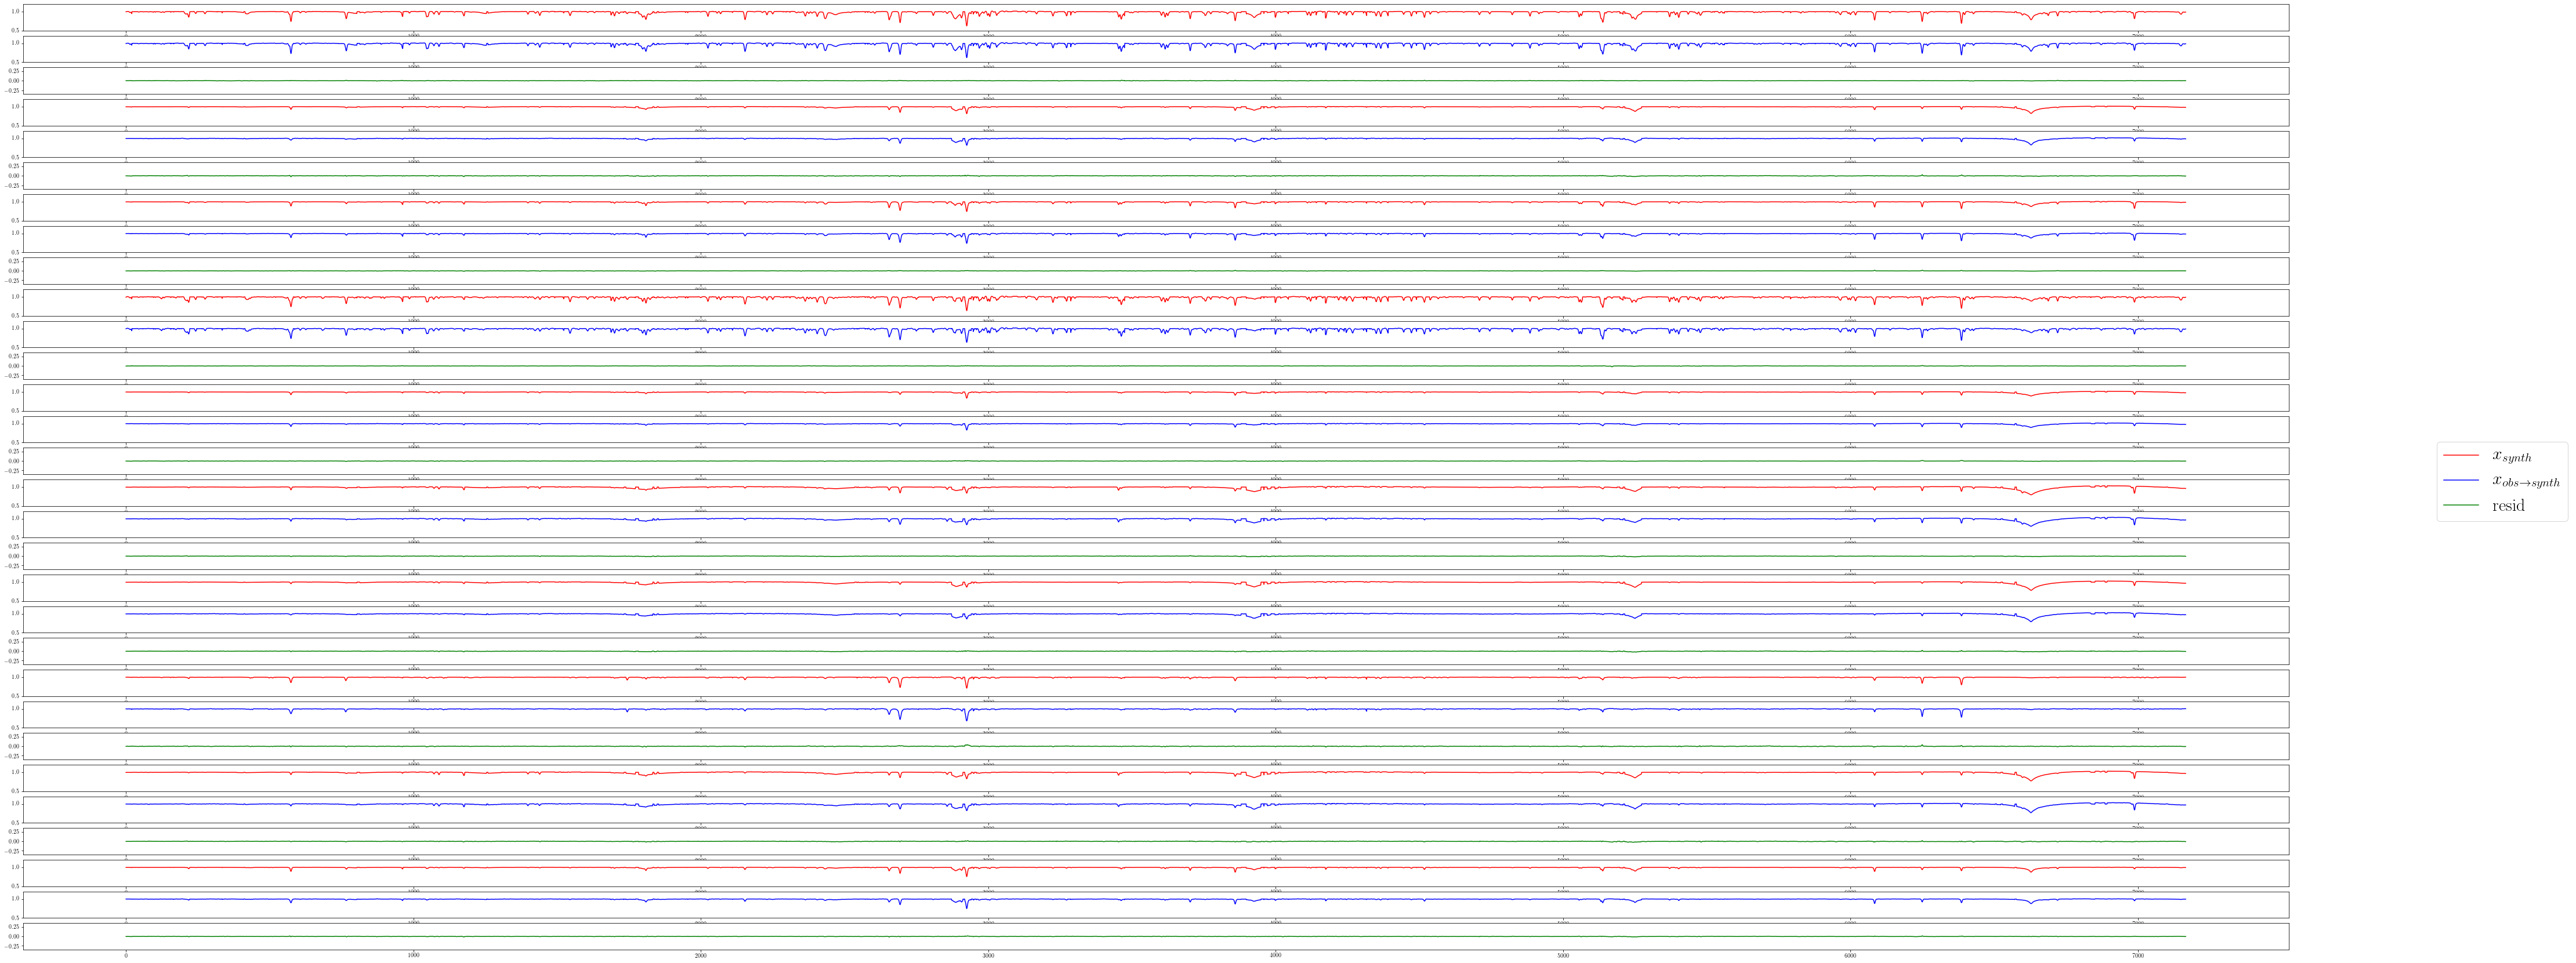

In [11]:
# Calculate residulal
x_synth_resid = (x_synth_val-x_obssynth)

plt.close('all')
# Plot test results
fig, axes = plt.subplots(30,1,figsize=(70, 30))
for i, indx in enumerate(test_indices):
    orig, = axes[i*3].plot(x_synth_val[indx],c='r')
    axes[i*3].set_ylim((0.5,1.2))
    pred, = axes[1+3*i].plot(x_obssynth[indx],c='b')
    axes[1+3*i].set_ylim((0.5,1.2))
    resid, = axes[2+3*i].plot(x_synth_resid[indx],c='g')
    axes[2+3*i].set_ylim((-0.35,0.35))
fig.legend([orig, pred, resid],[r'$x_{synth}$', r'$x_{obs\rightarrow synth}$', r'resid'],
          loc='center right', fontsize=30)  
plt.show()

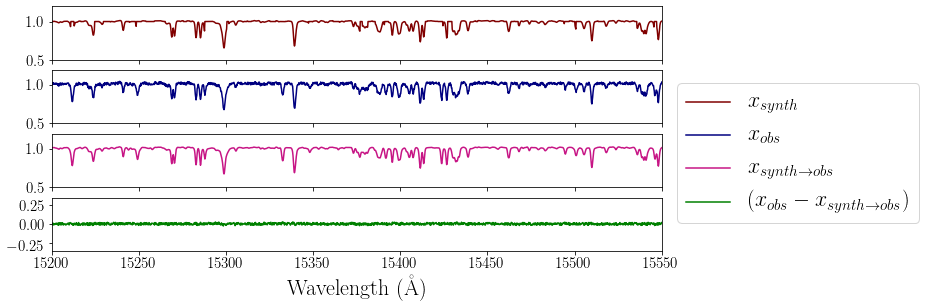

In [12]:
indx = 1
min_wave = 15200 # in Angstroms
max_wave = 15550

# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()[47:]

# Calculate residulal
x_resid = (x_obs_val-x_synthobs)

plt.close('all')
# Plot test results
fig, axes = plt.subplots(4,1,figsize=(14,4.5), sharex=True)
orig_synth, = axes[0].plot(wave_grid, x_synth_val[indx], c='maroon')
orig_obs, = axes[1].plot(wave_grid, x_obs_val[indx], c='navy')
pred, = axes[2].plot(wave_grid, x_synthobs[indx], c='mediumvioletred')
resid, = axes[3].plot(wave_grid, x_resid[indx], c='g')

for i in range(4):
    if i==3:
        axes[3].set_ylim((-0.35,0.35))
    else:
        axes[i].set_ylim((0.5,1.2))
    axes[i].tick_params(labelsize=15)
    
axes[0].set_xlim((min_wave,max_wave))
fig.legend([orig_synth, orig_obs, pred, resid],
           [r'$x_{synth}$',r'$x_{obs}$', r'$x_{synth \rightarrow obs}$', r'$(x_{obs}-x_{synth \rightarrow obs})$'],
          loc='center right', fontsize=22)
plt.xlabel(r'Wavelength (\AA)',fontsize=22)
fig.subplots_adjust(right=0.73)

#plt.savefig('../figures/synth_to_obs.png', transparent=True, pad_inches=0.2)
plt.show()

paynetopayne_nozsplit_1
Analyzing original spectra
Analyzing shared latent-space
Analyzing observed generated spectra
Analyzing synthetic generated spectra
Analyzing synthetic cycle-reconstructed spectra
Analyzing observed cycle-reconstructed spectra


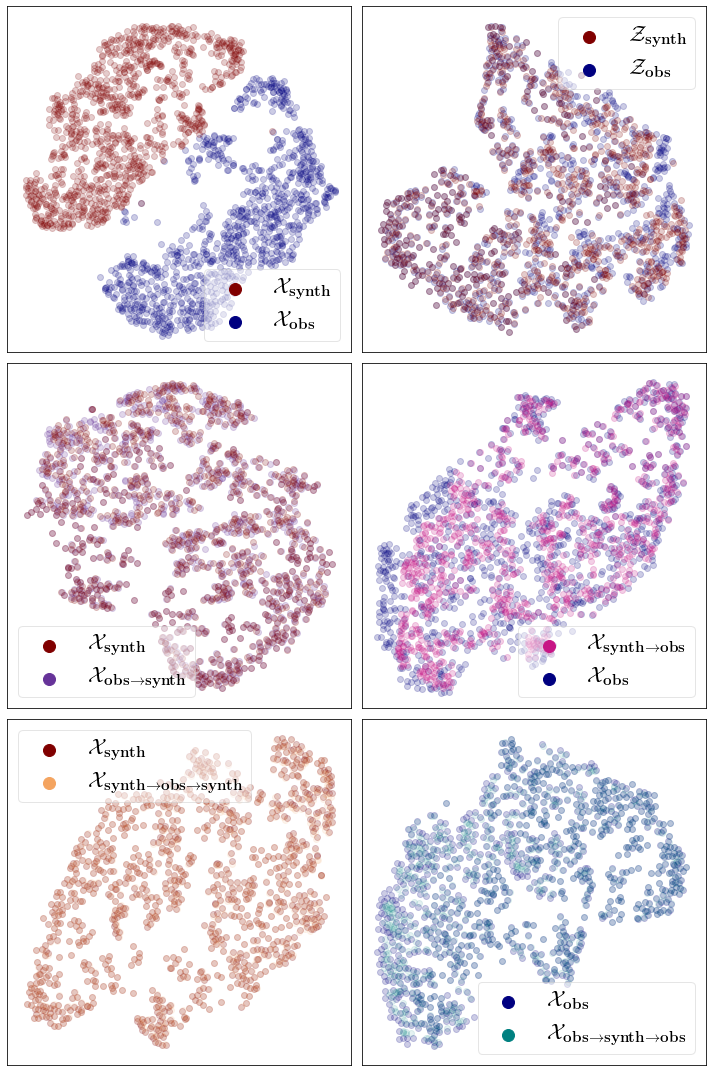

In [13]:
print(model_name)
# Run t-SNE analyses
tsne_domain_analysis(x_synth_val, x_obs_val, zsh_synth, zsh_obs, 
                     x_synthobs, x_obssynth, x_synthobssynth, x_obssynthobs)#,
                     #savename='../figures/tsne.png')